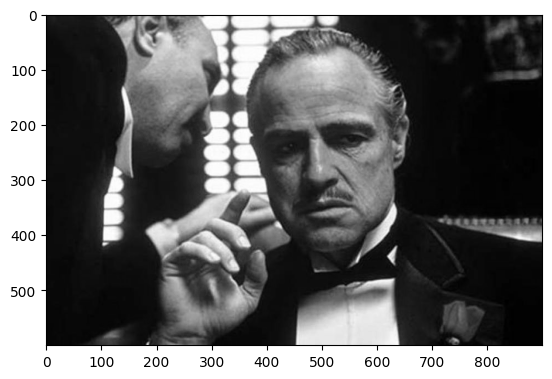

In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray
filename = "godfather.jpg"
img = mpimg.imread(filename)
img = rgb2gray(img)
plt.imshow(img, cmap='gray')

In [1]:
import numpy as np

def gaussian_kernel(size, sigma=1):
    # Adjust size to ensure a center
    size = int(size) // 2
    # Grid of (x, y) coordinates in [-size, size] range
    x, y = np.mgrid[-size:size+1, -size:size+1]
    sigmaSq = np.power(sigma, 2)
    # Norm coefficient
    normal = 1 / (2.0 * np.pi * sigmaSq)
    # Gaussian for (x,y) coords, pixel weight from center, sigma controls spread
    g =  np.exp(-((x**2 + y**2) / (2.0*sigmaSq))) * normal
    return g

In [9]:
import numpy as np

def convolve2d(image, kernel):
    """
    Apply a 2D convolution operation without padding.
    """
    kernel = np.flipud(np.fliplr(kernel))  # Flip the kernel
    output = np.zeros_like(image)  # Prepare the output array
    # Compute convolution
    for x in range(image.shape[1] - 2):
        for y in range(image.shape[0] - 2):
            # Apply elementwise multiplication and sum
            output[y+1, x+1] = (kernel * image[y:y+3, x:x+3]).sum()
    return output

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    # Convolve with Kx and Ky using custom convolve2d function
    Ix = convolve2d(img, Kx)
    Iy = convolve2d(img, Ky)
    
    # Compute gradient magnitude and direction
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255  # Normalize
    theta = np.arctan2(Iy, Ix)  # Gradient direction
    
    return (G, theta)

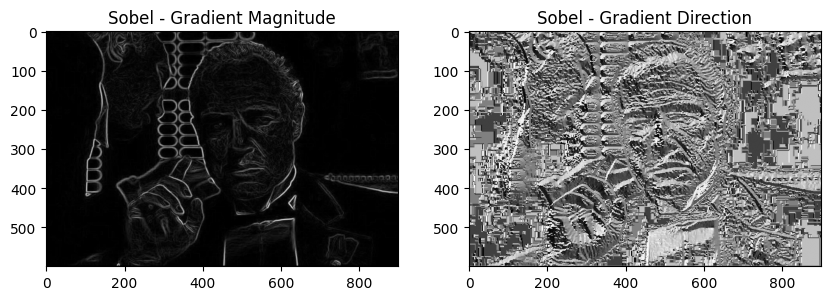

In [10]:
# Apply Sobel filter to the grayscale image
gradient_magnitude, gradient_direction = sobel_filters(img)

# Display the gradient magnitude as an image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Sobel - Gradient Magnitude")
plt.imshow(gradient_magnitude, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Sobel - Gradient Direction")
plt.imshow(gradient_direction, cmap='gray')

plt.show()

In [12]:
import numpy as np

def non_max_suppression(img, D):
    # Initialize matrix of zeros with the same size as img
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    
    # Convert angles from radians to degrees and adjust negative angles
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    # Iterate through each pixel in the image
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                # Initialize comparison pixels to max value (placeholders)
                q = 255
                r = 255
                
                # Horizontal edge
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                # Diagonal (positive slope) edge
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                # Vertical edge
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                # Diagonal (negative slope) edge
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                # Retain pixel if intensity is greater than neighbors along the gradient
                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                # Ignore pixels where neighbors are out of bounds
                pass
    
    return Z

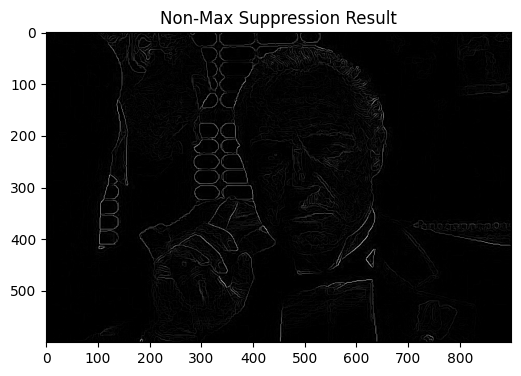

In [13]:
# Call the non_max_suppression function
suppressed_img = non_max_suppression(gradient_magnitude, gradient_direction)

# Display the resulting image
plt.figure(figsize=(6, 6))
plt.title("Non-Max Suppression Result")
plt.imshow(suppressed_img, cmap='gray')
plt.show()

In [14]:
import numpy as np

def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    # Maximum pixel intensity * highThresholdRatio
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    # Define intensity values for weak and strong pixels
    weak = np.int32(25)
    strong = np.int32(255)
    
    # Strong pixels 
    strong_i, strong_j = np.where(img >= highThreshold)
    # Non-relevant pixels
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    # Weak pixels (in-between thresholds)
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    # Mark strong pixels with high intensity value
    res[strong_i, strong_j] = strong
    # Mark weak pixels with lower intensity value
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

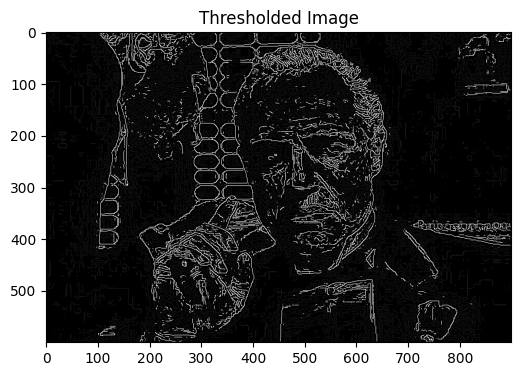

In [15]:
# Apply the threshold function to identify strong, weak, and non-relevant pixels
thresholded_img, weak, strong = threshold(suppressed_img)

# Display the thresholded image
plt.figure(figsize=(6, 6))
plt.title("Thresholded Image")
plt.imshow(thresholded_img, cmap='gray')
plt.show()

In [16]:
def hysteresis(img, weak, strong=255):
    # Get image dimensions
    M, N = img.shape  
    # Iterate through image pixels
    for i in range(1, M-1):
        for j in range(1, N-1):
            # Process only weak pixels
            if (img[i,j] == weak):
                try:
                    # Check surrounding pixels for a strong one
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        # Make weak pixel non-relevant if no strong pixel is around
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

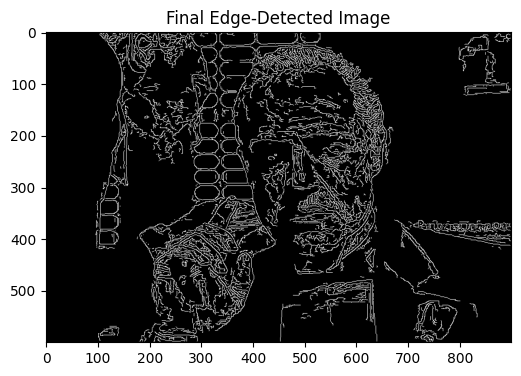

In [17]:
# Apply hysteresis to the thresholded image
final_img = hysteresis(thresholded_img, weak, strong)

# Display the final edge-detected image
plt.figure(figsize=(6, 6))
plt.title("Final Edge-Detected Image")
plt.imshow(final_img, cmap='gray')
plt.show()
